# Turkish Product Reviews — Sentiment Analysis

This notebook evaluates Turkish product review data using **incidelen/electra-small-turkish-sentiment-analysis-cased** for:
1) Baseline assessment with the published fine-tuned sentiment-analysis checkpoint, and
2) Domain Adaptive fine-tuning the same checkpoint for comparison.

> Data: In `turkish_product_reviews_train.csv`, columns are `sentence` and `sentiment` (0=NEGATIVE, 1=POSITIVE)

In [1]:
# If you have CUDA, install the appropriate torch version: https://pytorch.org/get-started/locally/

import torch, evaluate

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    pipeline,
)

print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [2]:
# Data
df = pd.read_csv("turkish_product_reviews_train.csv")
df.head()

,sentence,sentiment
0,fena değil paraya göre iyi.,1
1,ürün kaliteli ve çok kullanışlı kargo ya veril...,1
2,fiyat-performans karşılaştırması yaptığınızda ...,1
3,bu fiyata çok iyi,1
4,fiyat ve performans olarak gayet iyi,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235165 entries, 0 to 235164
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentence   235144 non-null  object
 1   sentiment  235165 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
df.value_counts("sentiment")

sentiment
1    220284
0     14881
Name: count, dtype: int64

In [5]:
# Data cleaning
df = df[['sentence', 'sentiment']].dropna()
df['sentiment'] = df['sentiment'].astype(int)

# Split train/validation/test with stratified split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))
print(f"Train / Val / Test: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")

Train / Val / Test: 164600 / 35272 / 35272


## 1) Baseline: published fine-tuned model
Using the fine-tuned checkpoint directly to predict sentiments on the test set.

In [6]:
# Base model

MODEL_NAME = "incidelen/electra-small-turkish-sentiment-analysis-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to("cuda" if torch.cuda.is_available() else "cpu").eval()

# Model Inference output is 3 but we only need 2

NEGATIVE, NEUTRAL, POSITIVE = 0, 1, 2  # model.config

def predict_binary(texts, batch_size=256, max_len=160): 
    predictions = []
    for i in range(0, len(texts), batch_size):
        inputs = tokenizer(texts[i:i+batch_size], truncation=True, padding=True, max_length=max_len, return_tensors="pt").to(model.device)
        with torch.inference_mode():
            logits = model(**inputs).logits[:, [NEGATIVE, POSITIVE]]
            predictions += logits.argmax(1).cpu().tolist()  # 0=neg, 1=pos
    return predictions

preds = predict_binary(test_ds["sentence"])
reports_base = classification_report(test_ds["sentiment"], preds)
acc_base = accuracy_score(test_ds["sentiment"], preds)
print(f"Test ACC: {acc_base:.4f}")
print(reports_base)

Test ACC: 0.8532
              precision    recall  f1-score   support

           0       0.28      0.85      0.42      2232
           1       0.99      0.85      0.92     33040

    accuracy                           0.85     35272
   macro avg       0.64      0.85      0.67     35272
weighted avg       0.94      0.85      0.88     35272



## 2) DAFT (DOMAIN ADAPTIVE FINE-TUNING) STAGE
Fine-tuning the published sentiment-analysis checkpoint on the training data.

In [7]:
# Model label configuration
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {v: k for k, v in id2label.items()}
accuracy = evaluate.load("accuracy")


# Tokenization
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_fn(batch):
    return tok(batch["sentence"], truncation=True, max_length=160)

train_tok = train_ds.map(tokenize_fn, batched=True, remove_columns=train_ds.column_names)
val_tok = val_ds.map(tokenize_fn, batched=True, remove_columns=val_ds.column_names)
test_tok = test_ds.map(tokenize_fn, batched=True, remove_columns=test_ds.column_names)

# Add labels
train_tok = train_tok.add_column("labels", train_ds['sentiment'])
val_tok = val_tok.add_column("labels", val_ds['sentiment'])
test_tok = test_tok.add_column("labels", test_ds['sentiment'])

# Compute metrics
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.argmax(axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

data_collator = DataCollatorWithPadding(tokenizer=tok)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id,
    ignore_mismatched_sizes=True)

Map:   0%|          | 0/164600 [00:00<?, ? examples/s]

Map:   0%|          | 0/35272 [00:00<?, ? examples/s]

Map:   0%|          | 0/35272 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at incidelen/electra-small-turkish-sentiment-analysis-cased and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Training arguments
use_cuda = torch.cuda.is_available()
args = TrainingArguments(
    output_dir="out-fine-tuned-model",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=0.6,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=use_cuda,
    logging_steps=50,
    report_to="none",
    seed=42,
)


# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    processing_class=tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.115200,0.111801,0.961386


TrainOutput(global_step=3087, training_loss=0.10175321764029999, metrics={'train_runtime': 384.9231, 'train_samples_per_second': 256.571, 'train_steps_per_second': 8.02, 'total_flos': 670664842226688.0, 'train_loss': 0.10175321764029999, 'epoch': 0.6001166407465007})

## 3) Evaluation with Fine-Tuned Model

The performance of the fine-tuned model on the test data is compared with the baseline model.

In [ ]:
# Test with the best model

best_dir = trainer.state.best_model_checkpoint or args.output_dir

# clf_best = pipeline("text-classification", model="mertafacan/electra-tr-product-reviews-daft", tokenizer="mertafacan/electra-tr-product-reviews-daft", use_fast=True, device=0 if torch.cuda.is_available() else -1)

clf_best = pipeline("text-classification", model=best_dir, tokenizer=best_dir, use_fast=True,
                    device=0 if torch.cuda.is_available() else -1)

sentences = list(test_ds["sentence"])
predictions = clf_best(sentences,batch_size=256,truncation=True,padding="max_length",max_length=160)
test_pred_labels = [1 if p["label"] == "POSITIVE" else 0 for p in predictions]

print(reports_base)
print("-"*60)
print(classification_report(test_ds["sentiment"], test_pred_labels))
print("*"*60)
print(f"[Base] Test accuracy: {acc_base:.4f}")
print(f"[After finetuning] Test accuracy: {accuracy_score(test_ds["sentiment"], test_pred_labels):.4f}")

Device set to use cuda:0


              precision    recall  f1-score   support

           0       0.28      0.85      0.42      2232
           1       0.99      0.85      0.92     33040

    accuracy                           0.85     35272
   macro avg       0.64      0.85      0.67     35272
weighted avg       0.94      0.85      0.88     35272

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.53      0.63      2232
           1       0.97      0.99      0.98     33040

    accuracy                           0.96     35272
   macro avg       0.87      0.76      0.80     35272
weighted avg       0.96      0.96      0.96     35272

************************************************************
[Base] Test accuracy: 0.8532
[After finetuning] Test accuracy: 0.9607


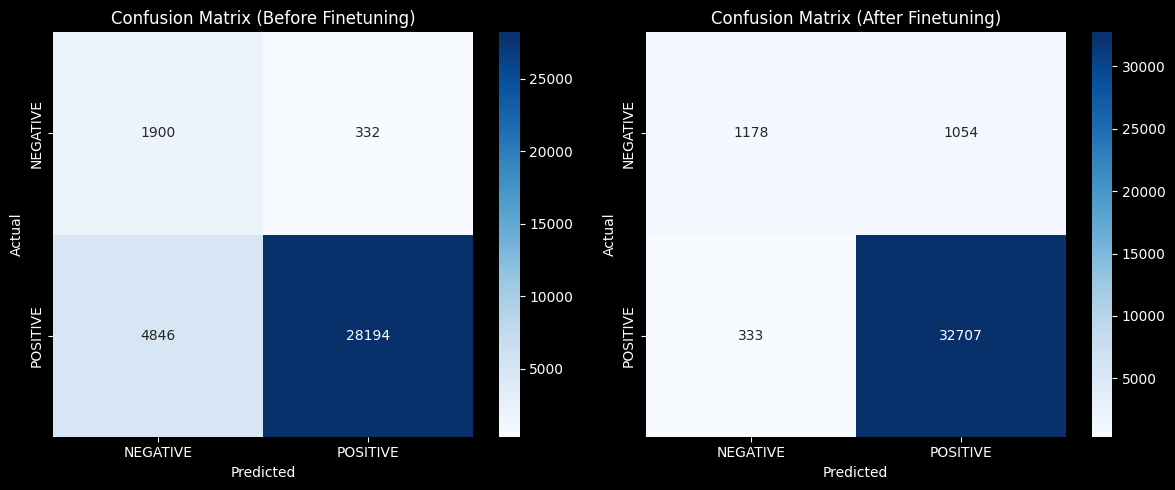

In [13]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_before = confusion_matrix(test_ds["sentiment"], preds)
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', xticklabels=['NEGATIVE', 'POSITIVE'], yticklabels=['NEGATIVE', 'POSITIVE'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Before Finetuning)')

cm_after = confusion_matrix(test_ds["sentiment"], test_pred_labels)
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues', xticklabels=['NEGATIVE', 'POSITIVE'], yticklabels=['NEGATIVE', 'POSITIVE'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (After Finetuning)')

plt.tight_layout()
plt.show()

## Conclusion & Key Takeaways

- After fine-tuning, test accuracy increased from **85.3% → 96.0% (+12.55%)**; error rate **14.7% → 4.0%** (−73%).
- **Class 1 (POSITIVE):** Recall **85% → 99%**; missed positives (FN) **−93%**.
- **Class 0 (NEGATIVE):** Recall **85% → 52%**; false positives **+218%**.
- In the positive class, the model now captures almost all examples (recall 85% → 99%) with only a slight drop in precision; in contrast, for the negative class, precision improved but recall fell significantly (85% → 52%). In short, the model has become **skewed toward the positive side.**

**What can be done?** Short term: **tune the decision threshold**, use **SMOTE/oversampling**, and apply **class weights** or **focal loss** to rebalance the minority class.